In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import re
import os
import time
from shapely.geometry import Point, Polygon, LineString,MultiPolygon
from shapely.ops import unary_union

In [2]:
messages = pd.read_csv('CleanedData.csv',index_col=0)
geoMessages = gpd.GeoDataFrame(messages)

In [111]:
geometryList = []
for i,(shape,geom) in enumerate(zip(geoMessages.GeometryType,geoMessages.Coordinates)):
    
    if shape == 'Point':
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]

        coor.append(tuple(ele))
        geo = Point(coor)
        geometryList.append(geo)
        
    elif shape == 'GeometryCollection':
        
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]
        
        tupleCoor = [tuple(ele[i:i+3]) for i in np.arange(0,len(ele),3)]
        if i == 4956 or i == 5681 or i == 1037:
            # Necessary because the two observations are LineStrings, or closer to linestrings than polygons.
            geo = LineString(tupleCoor)
        else:
            geo = Polygon(tupleCoor)
        geometryList.append(geo)
        
            

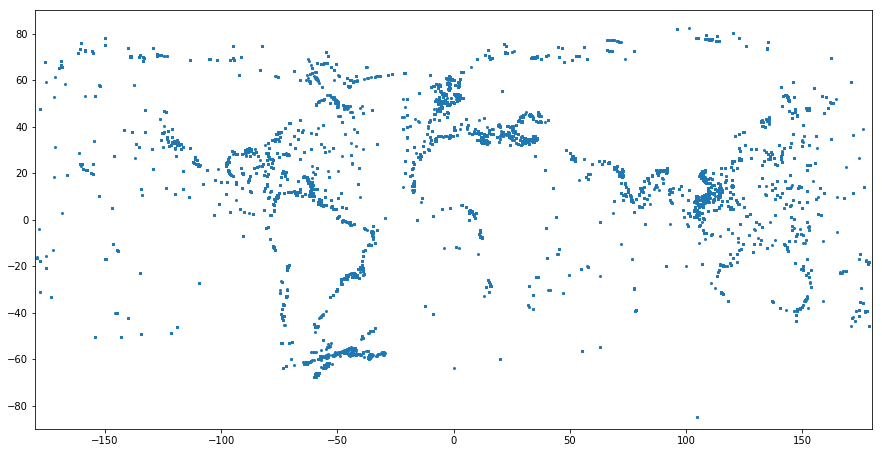

In [150]:
# Storing the geometries in something we can work with.
geometryFrame = gpd.GeoDataFrame(geometry=geometryList)

# Storing the centroids
geometryFrame['Centroids']=geometryFrame.centroid

reducedCentroidCoordinates = geometryFrame['Centroids'].drop_duplicates()
# Creating the reduced geometry dataframe
reducedGeometryFrame = geometryFrame.loc[reducedCentroidCoordinates.index]
reducedGeometryFrame = reducedGeometryFrame.reset_index(drop=True)
# Plotting the centroid of the area that each messeage spans
geometryFrame.centroid.plot(figsize=(15,15),markersize=4)
plt.ylim(-90,90)
plt.xlim(-180,180)
plt.show()

In [6]:
worldSeas = gpd.read_file('World_Seas_IHO_v3/World_Seas_IHO_v3.shp')

In [114]:
# Separate the ID of the different oceans based on the uniqueness of their ID's

areas = []

for i,ele in enumerate(worldSeas.ID):
    ele = re.sub('[^a-zA-Z]','',ele)
    if ele !='':
        areas.append(ele)
areas.append('NoAlpha')
area={ele:0 for ele in set(areas)}

listOfSeas = [[] for i in np.arange(len(area.keys()))]

for i,ele in enumerate(worldSeas.ID):
    ele = re.sub('[^a-zA-Z]','',ele)
    if ele in area.keys():
        place = [i for i,e in enumerate(area.keys()) if ele == e][0]
        listOfSeas[place].append(i)
    else:
        #print(i)
        place = [i for i,e in enumerate(area.keys()) if e == 'NoAlpha'][0]
        listOfSeas[place].append(i)
        
for i,e in enumerate(area.keys()):
    area[e] = listOfSeas[i]

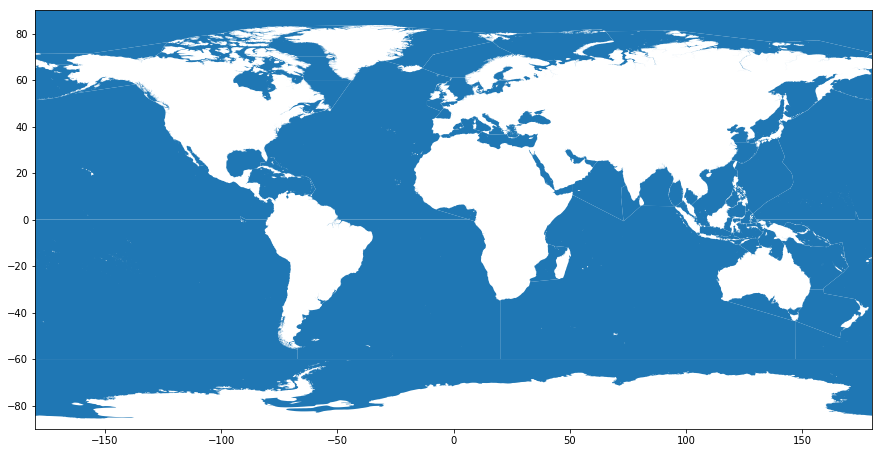

In [8]:
worldSeas.geometry.plot(figsize=(15,15))
plt.xlim(-180,180)
plt.ylim(-90,90)
plt.show()

In [115]:
navareaIV = worldSeas.loc[[18,19,20,21,26,27,28,31,32,33,37,39,40,41,43,44,45,55,56,57,58,74,75,76,77,78,79,80,81,84,87,89,90,95,97,99]]
navareaIV = navareaIV.reset_index(drop=True)
navareaXII = worldSeas.loc[[17,22,23,51,52,53,54,72,73,91,92]]
navareaXII = navareaXII.reset_index(drop=True)
hydroLant = worldSeas.loc[[0,61,100]]
hydroLant = hydroLant.reset_index(drop=True)
hydroPac = worldSeas.loc[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,34,35,36,38,42,46,47,48,49,50,63,64,65,66,67,68,69,70,71,88,96]]
hydroPac = hydroPac.reset_index(drop=True)
hydroArc = worldSeas.loc[[24,25,29,30,59,60,62,82,83,85,86,93,94,98]]
hydroArc = hydroArc.reset_index(drop=True)

In [151]:
start = time.time()
goal = reducedGeometryFrame.shape[0]
subSeas = [navareaIV,navareaXII,hydroArc,hydroLant,hydroPac]
subSeasIndices = [[] for i in np.arange(len(subSeas))]
counter = 0
countUniques = []
indices = []
tempFrame = gpd.GeoDataFrame({'geometry':reducedGeometryFrame['Centroids']},geometry='geometry',crs = worldSeas.crs)
whereAreWe = 1
increaseSearch = 1
foundByIntersect = {}

while(len(countUniques) < goal):
    print('This is the %ith iteration and currently %i observations has been divided into the five groups' % (whereAreWe,len(countUniques)))
    indices = []
    if whereAreWe == 1:
        for j,subsea in enumerate(subSeas):

            subsea.crs = worldSeas.crs
            temp = gpd.sjoin(tempFrame,subsea,how='inner',op='within')
            subSeasIndices[j] += list(temp.index)
            
            countUniques += list(temp.index)
            counter += len(temp.index)
        
    else:
        
        tempFrame = gpd.GeoDataFrame({'geometry':tempFrame.buffer(increaseSearch)},geometry='geometry',crs = worldSeas.crs)
        #print('\nThis is the previously found observation through "intersection"',foundByIntersect)
        for j,subsea in enumerate(subSeas):

            temp = gpd.sjoin(tempFrame,subsea,how='inner',op='intersects')
            #print('\nThe number of observations being added are',len(temp.index))
            
            countUniques += list(temp.index)
            uniqueKeys = 0
            for i in temp.index:
                if (j,increaseSearch,i) not in foundByIntersect.keys():
                    uniqueKeys += 1
                    foundByIntersect[(j,increaseSearch,i)] = i
            #print('\nThe number of unique observations added is',uniqueKeys)
            #print('\nThe observations, found through "intersection" has been added, and the dictionary now looks like the following\n')
            #print(foundByIntersect)
    
        increaseSearch += 1
    countUniques = list(set(countUniques))
    tempFrame = gpd.GeoSeries(reducedGeometryFrame['Centroids'].drop(countUniques))
    whereAreWe += 1
    if whereAreWe > 5:
        break
end = time.time()
print('It took %.3f seconds and %i iterations, to divide %i observations into the five areas' % ((end-start),
                                                                                                 whereAreWe,len(countUniques)))

This is the 1th iteration and currently 0 observations has been divided into the five groups
This is the 2th iteration and currently 2842 observations has been divided into the five groups
This is the 3th iteration and currently 3133 observations has been divided into the five groups
This is the 4th iteration and currently 3134 observations has been divided into the five groups
This is the 5th iteration and currently 3134 observations has been divided into the five groups
It took 3593.856 seconds and 6 iterations, to divide 3135 observations into the five areas


In [152]:
##################################### Sorting the observations found using 'intersect'
# Remember that the keys are lised as: (Area,BufferArea,Observation)
sortedfoundByIntersect = sorted(foundByIntersect.items(), key = lambda kv: kv[1],reverse = True)
UniquesFBI = []
DuplicatesFBI = {}

# Looping over all values in the dictionary, and separate the values based on their occruence.
for key,value in foundByIntersect.items():
    
    occurences = [i for i,e in enumerate(foundByIntersect.values()) if e == value]
    
    if len(occurences) > 1:
        DuplicatesFBI[key]=(value)
        
    else:
        # If the value (the observation) is unique, we don't care about the buffer area used to find that particular observation
        # and the observation is assigned to the associated area.
        UniquesFBI.append(value)
        subSeasIndices[key[0]] += [value]

# Getting the unique duplicate observations to loop over
duplicateObs = list(set(DuplicatesFBI.values()))

# Creating a new dataframe from those observations

for obs in duplicateObs:
    
    # Extracting the areas that they intersect 
    keys = [key for key,value in DuplicatesFBI.items() if value == obs]
    print('The key-pairs of interest is here:',keys,'\n')
    belongsToArea = 0
    area = 0
    
    for subkey in keys:
        
        # Creating a new dataframe from those observations
        tempFrame = gpd.GeoSeries(reducedGeometryFrame['Centroids'].loc[obs])
        tempFrame = gpd.GeoDataFrame({'geometry':tempFrame.buffer(subkey[1])},geometry='geometry',crs = worldSeas.crs)
        
        areaOfInterst = subSeas[subkey[0]]
        
        # We go over all the possible geometries within the area of interst, to check of the observation intersects any of them
        for i,possibleIntersectArea in enumerate(areaOfInterst.geometry):
            # If the observation intersects a geometry, the area of intersection is calculated, and the observations
            # belongs to the area in which the area of intersection is largest.
            if tempFrame.geometry.loc[0].intersects(possibleIntersectArea):
                if ((tempFrame.geometry.loc[0].intersection(possibleIntersectArea).area/possibleIntersectArea.area)*100)>area:
                    area = (tempFrame.geometry.loc[0].intersection(possibleIntersectArea).area/possibleIntersectArea.area)*100
                    belongsToArea = subkey[0]
                    #print('The intersection amount are',
                    #      (tempFrame.geometry.loc[0].intersection(possibleIntersectArea).area/possibleIntersectArea.area)*100,'\n')
                #print(subkey[0],i,'size of area of intersect',
                #      tempFrame.geometry.loc[0].intersection(possibleIntersectArea).area,'\n')
    
    print(obs,'belongs to the area',belongsToArea,'\n')
    subSeasIndices[belongsToArea] += [obs]

uniqueIndices = []
for i in subSeasIndices:
    uniqueIndices += i
    
print('The number of unique indices are at this moment',len(uniqueIndices),
      'which is equivalent to %.3f of the total observations' % (len(uniqueIndices)/reducedGeometryFrame.shape[0]))

The key-pairs of interest is here: [(0, 1, 231), (3, 1, 231)] 

231 belongs to the area 0 

The key-pairs of interest is here: [(0, 1, 232), (3, 1, 232)] 

232 belongs to the area 0 

The key-pairs of interest is here: [(0, 1, 233), (3, 1, 233)] 

233 belongs to the area 0 

The key-pairs of interest is here: [(1, 1, 2634), (4, 1, 2634)] 

2634 belongs to the area 4 

The key-pairs of interest is here: [(0, 4, 394), (1, 4, 394)] 

394 belongs to the area 0 

The key-pairs of interest is here: [(0, 1, 143), (3, 1, 143)] 

143 belongs to the area 3 

The key-pairs of interest is here: [(0, 1, 2257), (2, 1, 2257)] 

2257 belongs to the area 2 

The key-pairs of interest is here: [(0, 1, 146), (3, 1, 146)] 

146 belongs to the area 3 

The key-pairs of interest is here: [(0, 1, 1654), (1, 1, 1654)] 

1654 belongs to the area 0 

The key-pairs of interest is here: [(0, 1, 1562), (2, 1, 1562)] 

1562 belongs to the area 0 

The key-pairs of interest is here: [(0, 1, 189), (3, 1, 189)] 

189 

In [153]:
# Locating the observations that couldn't be classified
noAreaObs = [i for i,e in enumerate(reducedGeometryFrame.index) if e not in uniqueIndices]

In [154]:
noAreaObs

[1154]

Let see if there is a reason why the observation/-s can't be assigned to an area

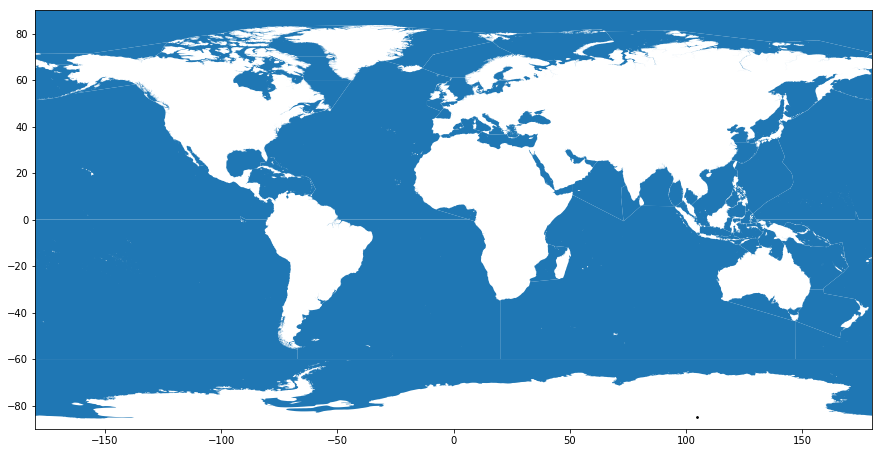

In [155]:
noAreaFrame = gpd.GeoDataFrame({'geometry':reducedGeometryFrame['Centroids'].loc[noAreaObs]},geometry='geometry',
                               crs=worldSeas.crs)
base = worldSeas.geometry.plot(figsize=(15,15))
noAreaFrame.plot(ax=base,figsize=(15,15),color='black',markersize=3)
plt.xlim(-180,180)
plt.ylim(-90,90)
plt.show()

It is seen that the reason why the observation isn't possible to assign (with the buffers tried), is due to the fact that the observation is located within land. The way the assigning-procedure works, is that warnings are expected to be located near or in a sea. Based on that, this single observation is assigned to the 'hydroArc' area. 

In [156]:
# subSeas = [navareaIV,navareaXII,hydroArc,hydroLant,hydroPac], so the index is therefore 2 below
subSeasIndices[2] += [noAreaObs[0]]

In [157]:
uniqueIndices = []
for i in subSeasIndices:
    uniqueIndices += i
    
print('The number of unique indices are at this moment',len(uniqueIndices),
      'which is equivalent to %.3f of the total observations' % (len(uniqueIndices)/reducedGeometryFrame.shape[0]))

The number of unique indices are at this moment 3136 which is equivalent to 1.000 of the total observations


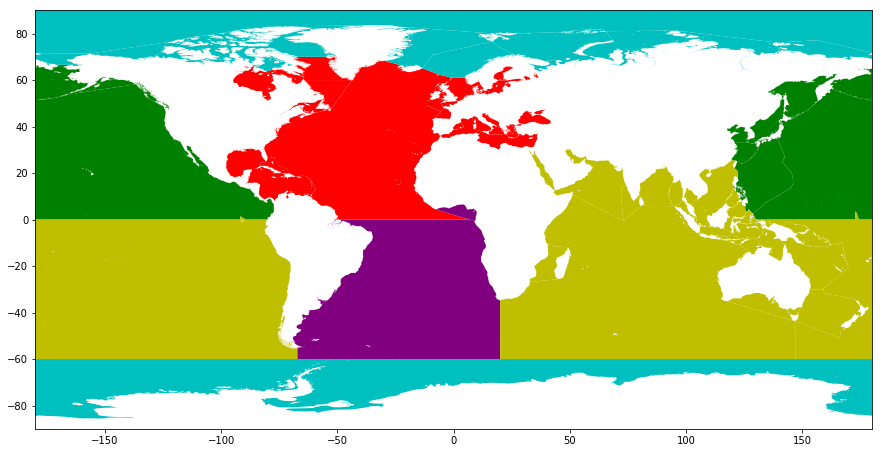

In [9]:
nIV =navareaIV.plot(color='r',figsize=(15,15))
nXII = navareaXII.plot(ax=nIV,color='g',figsize=(15,15))
hL = hydroLant.plot(ax=nXII,color='purple',figsize=(15,15))
hP = hydroPac.plot(ax=hL,color='y',figsize=(15,15))

hydroArc.plot(ax=hP,color='c',figsize=(15,15))
plt.xlim(-180,180)
plt.ylim(-90,90)
plt.show()

In [158]:
# The indices are now saved to separate text files.
writeOut = {'navareaIV':subSeasIndices[0],'navareaXII':subSeasIndices[1],'hydroArc':subSeasIndices[2],
            'hydroLant':subSeasIndices[3],'hydroPac':subSeasIndices[4]}
import os
try:
    os.mkdir('AreaIndices')
except:
    None
for name,var in writeOut.items():

    with open(('AreaIndices/'+name +'.txt'),'w') as textfile:
        
        for ele in var:
            textfile.write(str(ele)+'\n')  